# NLP Super Stars --  A Natural Language Processing Project
Jared Vahle, Joshua Bryant, Hector Rodriguez, Sarah Lawson Woods - November 2021

In [1]:
import requests
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pprint import pprint

from wordcloud import WordCloud

import os
import json

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from prepare import *

import nltk
import nltk.sentiment

import warnings


In [2]:
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Acquire

In [3]:
#pulling in json file
data = pd.read_json('data.json')

In [4]:
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


### Acquire Takeaway
- The data was acquired by scraping the starred repos on GitHub number 1001-1009 and then 10010-10060; we chose to not use the first 1000 in the list since many of them were guides and incomplete also we wanted to make sure we had a good variety that were not all in order so we did not pull the list totally in order. 
- We brought in 506 rows initially 

# Prepare

In [5]:
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [6]:
# removed languages that were 'none'
data = data.dropna()

In [7]:
len(data)

506

In [8]:
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Shell                13
Swift                13
HTML                 12
Rust                 11
Kotlin                9
C#                    9
Ruby                  9
Jupyter Notebook      6
Vue                   6
PHP                   6
Vim script            6
CSS                   5
Objective-C           3
TeX                   2
Haskell               2
CoffeeScript          2
Elixir                2
Lua                   2
Rascal                1
Makefile              1
Clojure               1
AsciiDoc              1
Dart                  1
Standard ML           1
OCaml                 1
Crystal               1
Emacs Lisp            1
Dockerfile            1
Batchfile             1
Name: language, dtype: int64

In [9]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [10]:
len(data)

357

<AxesSubplot:>

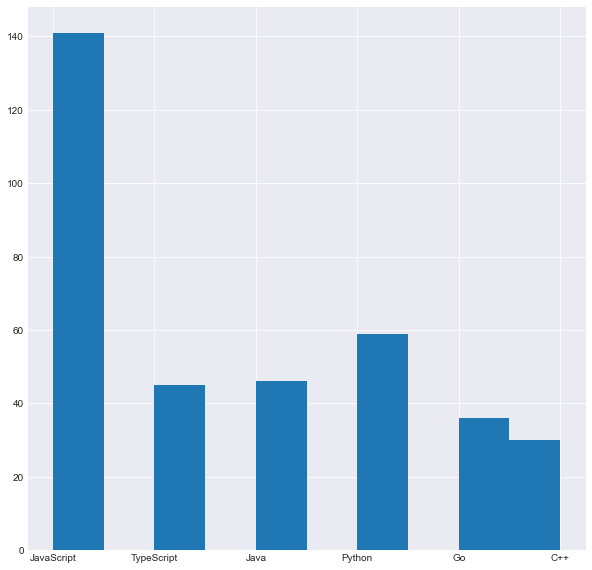

In [11]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'mid')

In [12]:
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [13]:
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

In [14]:
data = data.drop(columns = ['readme_contents'])

In [15]:
data = get_columns(data)

In [16]:
def is_javascript(row):
    if row['language'] == 'JavaScript':
        return True
    else:
        return False

In [17]:
data['is_javascript'] = data.apply(lambda row: is_javascript(row), axis=1)

In [18]:
data['sentiment'] = data.clean.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [19]:
data

,repo,language,clean,stemmed,lemmatized,message_length,word_count,avg_word_length,is_javascript,sentiment
3,tailwindlabs/tailwindcss,JavaScript,utilityfirst cs framework rapidly building cus...,utilityfirst cs framework rapidli build custom...,utilityfirst c framework rapidly building cust...,549,48,11.437500,True,0.9349
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...,1882,209,9.004785,True,0.8481
7,ianstormtaylor/slate,TypeScript,completely customizable framework building ric...,complet customiz framework build rich text edi...,completely customizable framework building ric...,7461,718,10.391365,False,0.9986
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,3120,311,10.032154,True,0.8720
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,2027,74,27.391892,False,0.9729
...,...,...,...,...,...,...,...,...,...,...
551,TheAlgorithms/Java,Java,httpsgithubcomthealgorithmsjavatreedevelopment...,httpsgithubcomthealgorithmsjavatreedevelop jav...,httpsgithubcomthealgorithmsjavatreedevelopment...,4485,243,18.456790,False,0.0000
555,tornadoweb/tornado,Python,tornado web server image httpsbadgesgitterimjo...,tornado web server imag httpsbadgesgitterimjoi...,tornado web server image httpsbadgesgitterimjo...,911,92,9.902174,False,0.6808
557,gulpjs/gulp,JavaScript,streaming build system npm versionnpmimagenpmu...,stream build system npm versionnpmimagenpmurl ...,streaming build system npm versionnpmimagenpmu...,6677,734,9.096730,True,0.9963
558,alibaba/weex,C++,weex framework building mobile crossplatform u...,weex framework build mobil crossplatform ui bu...,weex framework building mobile crossplatform u...,807,43,18.767442,False,0.6124


# Explore 

In [20]:
data.language.value_counts(normalize = True)

JavaScript    0.394958
Python        0.165266
Java          0.128852
TypeScript    0.126050
Go            0.100840
C++           0.084034
Name: language, dtype: float64

In [21]:
data.language.value_counts()

JavaScript    141
Python         59
Java           46
TypeScript     45
Go             36
C++            30
Name: language, dtype: int64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 3 to 559
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   repo             357 non-null    object 
 1   language         357 non-null    object 
 2   clean            357 non-null    object 
 3   stemmed          357 non-null    object 
 4   lemmatized       357 non-null    object 
 5   message_length   357 non-null    int64  
 6   word_count       357 non-null    int64  
 7   avg_word_length  355 non-null    float64
 8   is_javascript    357 non-null    bool   
 9   sentiment        357 non-null    float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 28.2+ KB


In [23]:
data.describe()

,message_length,word_count,avg_word_length,sentiment
count,357.000000,357.000000,355.000000,357.000000
mean,8929.117647,829.109244,11.917034,0.819141
std,17912.084390,1612.111164,4.654157,0.412686
min,0.000000,0.000000,5.849530,-0.995700
25%,2336.000000,194.000000,9.107213,0.927400
50%,4041.000000,364.000000,10.483871,0.989000
75%,7300.000000,734.000000,13.129932,0.996400
max,141410.000000,13110.000000,41.034483,1.000000


In [24]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [25]:
# combine all messages in single string by label

JavaScript_words = clean(' '.join(data[data.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(data[data.language == 'Python'].stemmed))
TS_words = clean(' '.join(data[data.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(data[data.language == 'Java'].stemmed))
Go_words = clean(' '.join(data[data.language == 'Go'].stemmed))
C_words = clean(' '.join(data[data.language == 'C++'].stemmed))
Non_JavaScript = clean(' '.join(data[data.language != 'JavaScript'].stemmed))
all_words = clean(' '.join(data.stemmed))

In [26]:
# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [27]:
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

use                                               318
const                                             168
react                                             131
redux                                             126
function                                          121
                                                 ... 
employershttpcorporatespecmembershipgraphqlorg      1
fourth                                              1
openhttpscodexsojoin                                1
behaviour                                           1
ucoconent                                           1
Length: 4969, dtype: int64

In [28]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
non_JavaScript_freq = pd.Series(Non_JavaScript.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [29]:
word_counts = pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq,non_JavaScript_freq, all_words_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['javascript','python','java','go','c','ts','NonJS','all']
word_counts.head()

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
javascript,837,42,3,1,2,58,106,943
code,792,209,94,65,71,77,516,1308
function,790,151,19,43,82,121,416,1206
j,772,7,2,7,48,94,158,930


In [30]:
word_counts.sort_values('all', ascending = False).head(20)

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
file,705,526,54,166,109,38,893,1598
instal,480,568,49,141,125,103,986,1466
code,792,209,94,65,71,77,516,1308
support,478,325,124,99,117,91,756,1234
function,790,151,19,43,82,121,416,1206
project,672,160,97,51,54,92,454,1126
1,353,339,74,113,137,89,752,1105
option,578,360,16,66,27,38,507,1085
run,418,254,89,117,64,86,610,1028


In [31]:
word_counts.sort_values(['NonJS','javascript'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
takehom,353,0,0,0,0,0,0,353
onsit,277,0,0,0,0,0,0,277
usa,188,0,0,0,0,0,0,188
uk,159,0,0,0,0,0,0,159
nightmar,120,0,0,0,0,0,0,120
ccxt,119,0,0,0,0,0,0,119
san,118,0,0,0,0,0,0,118
autoprefix,108,0,0,0,0,0,0,108
london,103,0,0,0,0,0,0,103
est,99,0,0,0,0,0,0,99


In [32]:
word_counts.sort_values(['javascript','NonJS'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
softwareoss,0,750,0,0,0,0,750,750
py,0,253,0,0,0,0,253,253
ycm,0,201,0,0,0,0,201,201
cpp,0,27,0,0,93,0,120,120
cmake,0,21,0,0,60,0,81,81
viper,0,0,0,81,0,0,81,81
viml,0,79,0,0,0,0,79,79
filetyp,0,70,0,3,0,4,77,77
struct,0,0,0,24,49,0,73,73
airflow,0,71,0,0,0,0,71,71


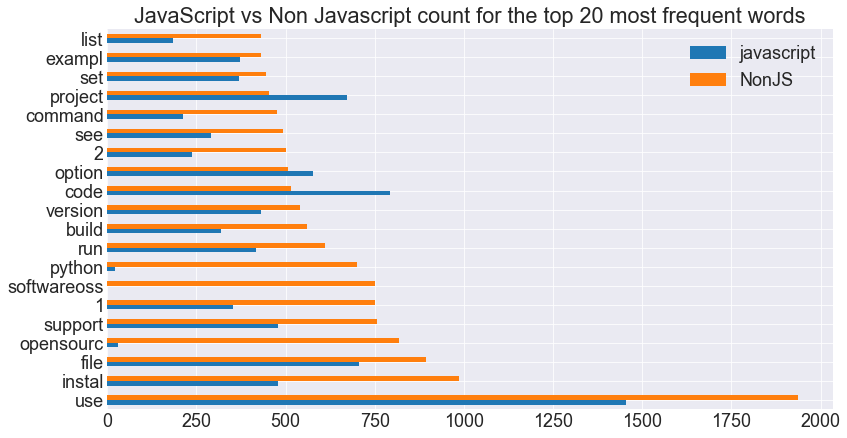

In [33]:
plt.rc('font', size=18)
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh()
plt.title('JavaScript vs Non Javascript count for the top 20 most frequent words')
plt.show()

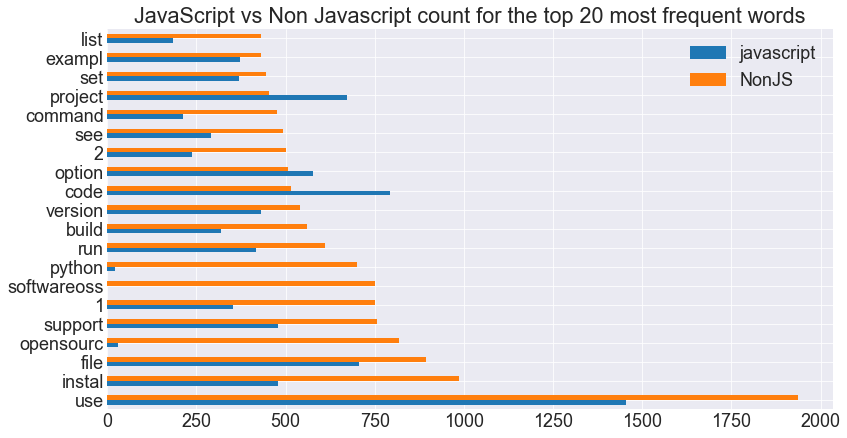

In [34]:
plt.rc('font', size=18)
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh()
plt.title('JavaScript vs Non Javascript count for the top 20 most frequent words')
plt.show()

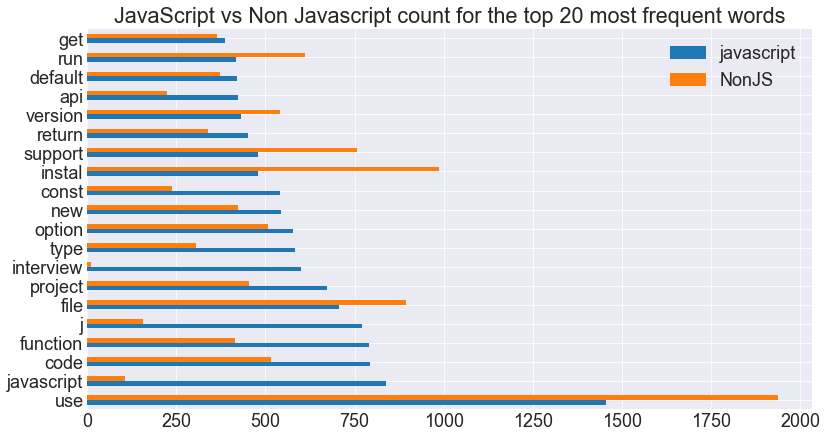

In [35]:
plt.rc('font', size=18)
word_counts.sort_values('javascript', ascending=False).head(20)[['javascript','NonJS']].plot.barh()
plt.title('JavaScript vs Non Javascript count for the top 20 most frequent words')
plt.show()

<Figure size 1152x648 with 0 Axes>

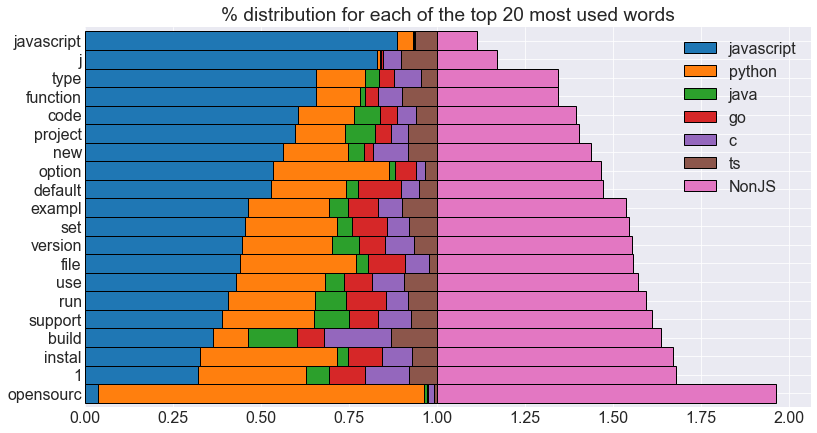

In [36]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% distribution for each of the top 20 most used words')
plt.show()

Text(0.5, 1.0, 'Top 10 most common Non JavaScript bigrams')

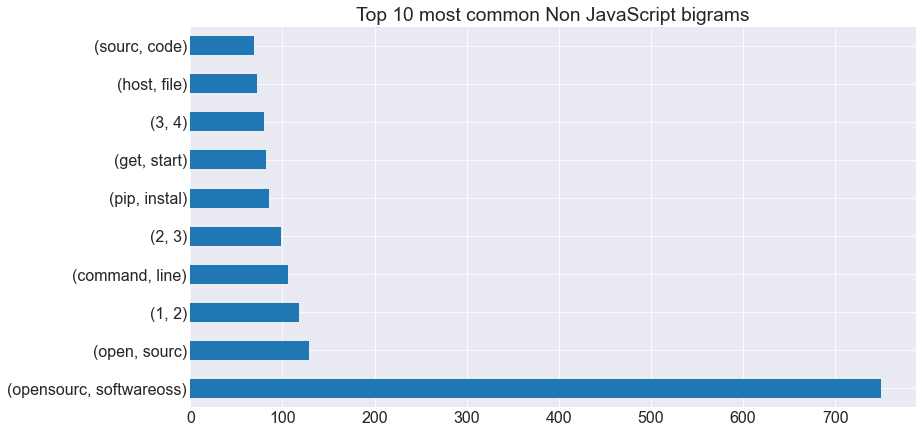

In [37]:
pd.Series(nltk.bigrams(Non_JavaScript.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Non JavaScript bigrams')

Text(0.5, 1.0, 'Top 10 most common JavaScript bigrams')

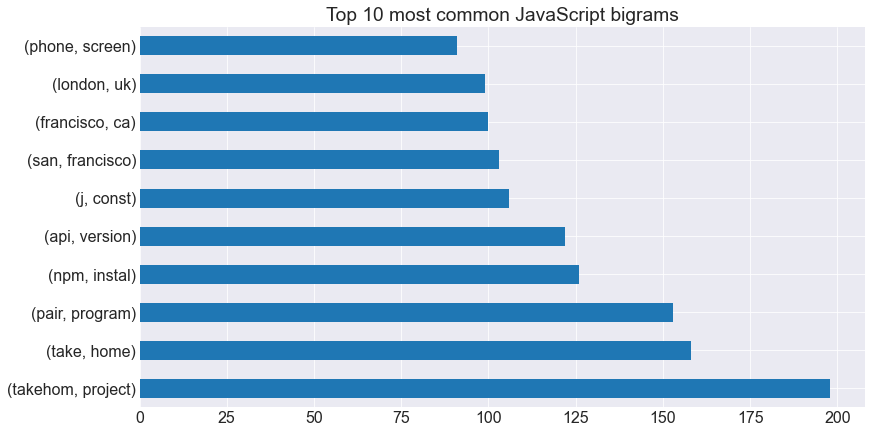

In [38]:
pd.Series(nltk.bigrams(JavaScript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common JavaScript bigrams')

Text(0.5, 1.0, 'Top 10 most common Java bigrams')

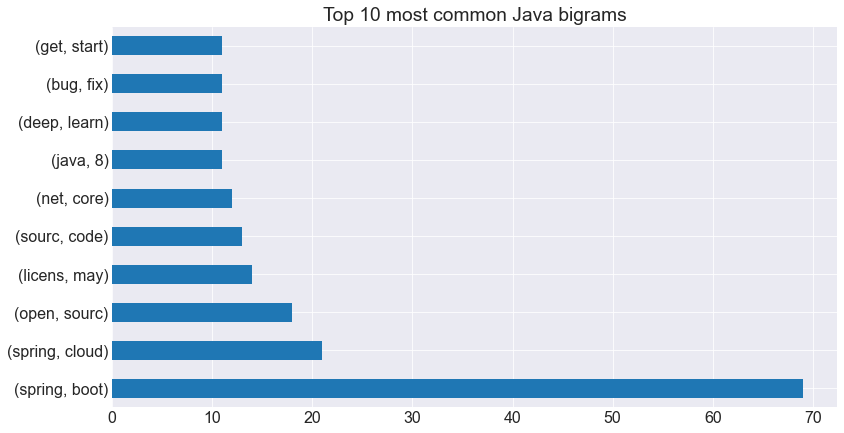

In [39]:
pd.Series(nltk.bigrams(Java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Java bigrams')

Text(0.5, 1.0, 'Top 10 most common Python bigrams')

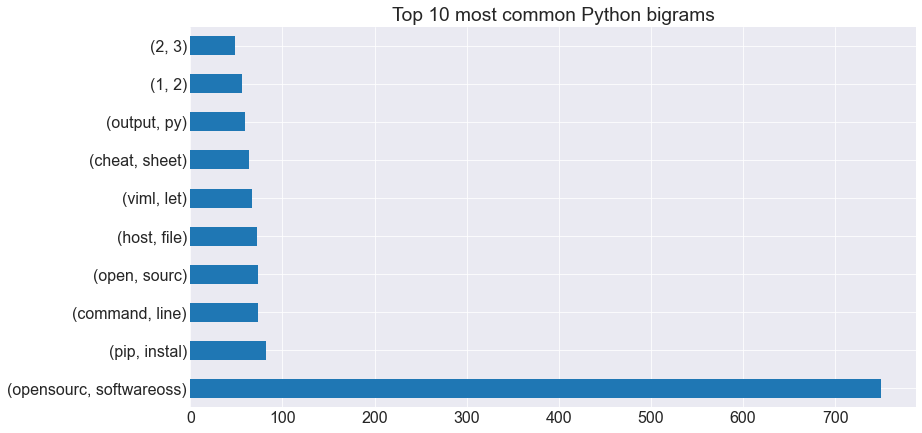

In [40]:
pd.Series(nltk.bigrams(Python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Python bigrams')

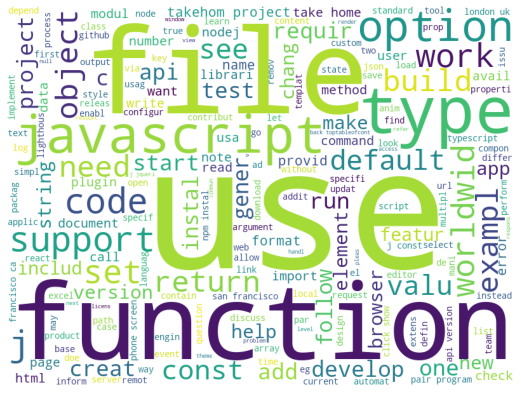

In [41]:
img = WordCloud(background_color='white', width=800, height=600).generate(JavaScript_words)
plt.imshow(img)
plt.axis('off')
plt.show()

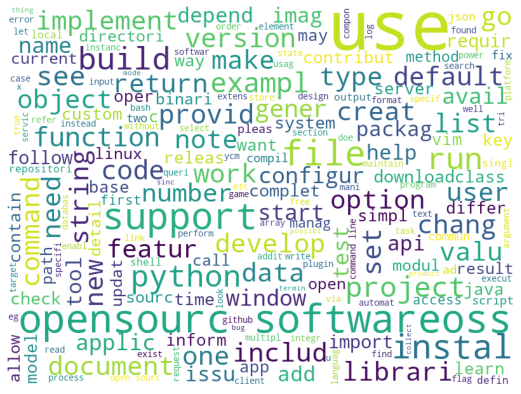

In [42]:
img = WordCloud(background_color='white', width=800, height=600).generate(Non_JavaScript)
plt.imshow(img)
plt.axis('off')
plt.show()

In [43]:
# Might decide to return to prepare to take out 'use'

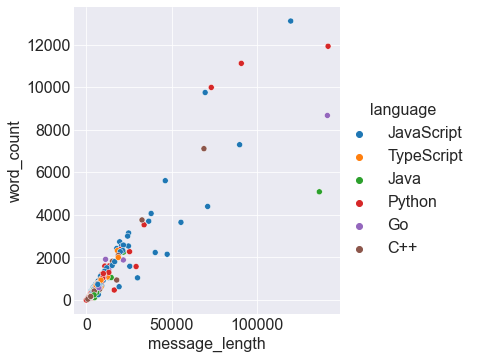

In [44]:
sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language')

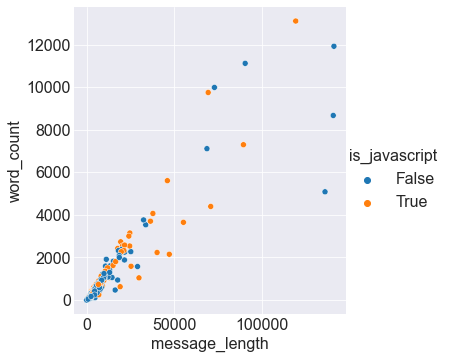

In [45]:
sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript')

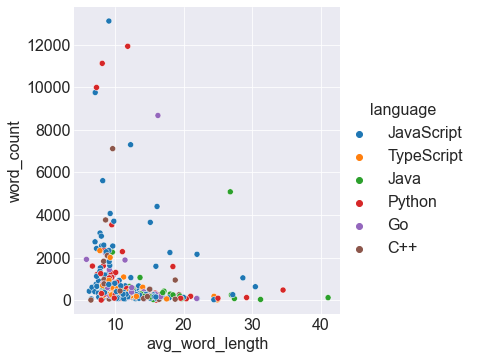

In [46]:
sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language')

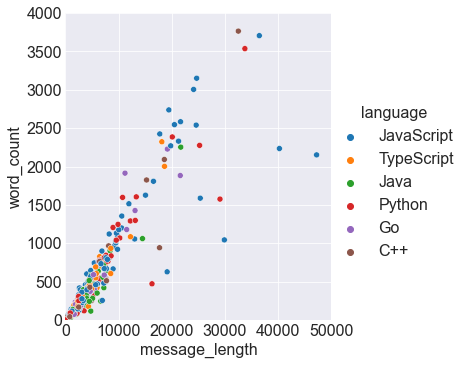

In [47]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language')
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))

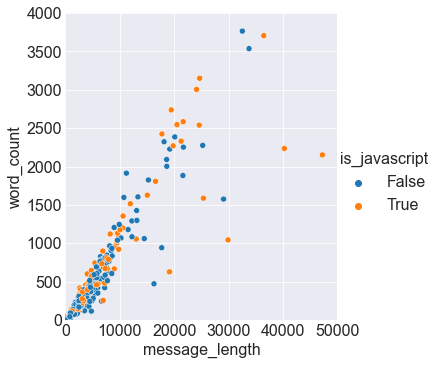

In [48]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript')
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))

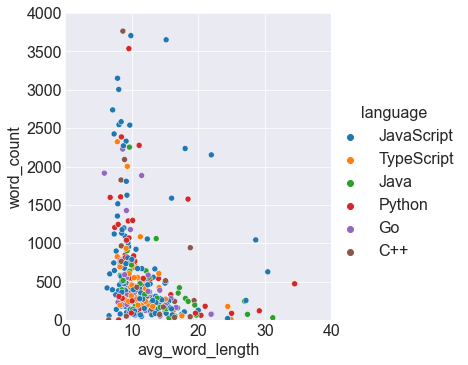

In [49]:
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language')
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,40))

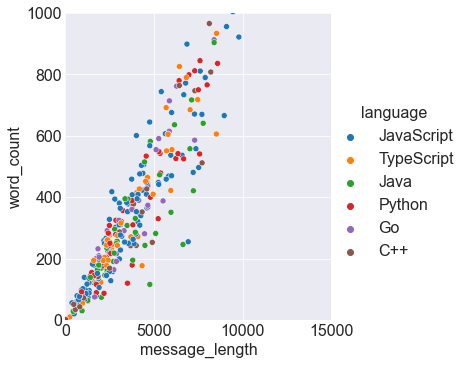

In [50]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language')
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))

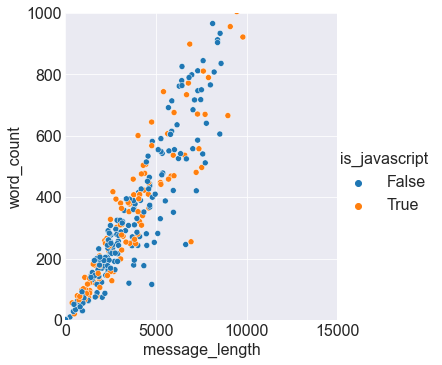

In [51]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript')
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))

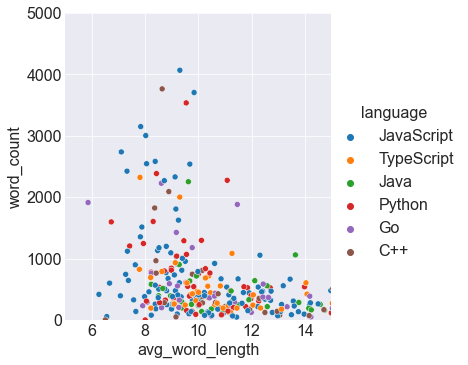

In [52]:
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language')
plot.set(ylim=(0, 5000))
plot.set(xlim=(5,15))

In [53]:
data.groupby('language')['message_length','word_count','sentiment'].agg(['mean','median'])

message_length          word_count        sentiment         
                     mean median         mean median      mean   median
language                                                               
C++           7950.300000   3754   779.633333    280  0.857807  0.98710
Go            9014.944444   4299   761.805556    364  0.733331  0.98955
Java          7136.369565   3417   457.326087    256  0.670570  0.96590
JavaScript    9918.340426   4095   950.808511    408  0.869337  0.99030
Python       11676.101695   5336  1179.101695    525  0.786159  0.98880
TypeScript    4644.422222   3772   455.777778    316  0.899844  0.99150

In [54]:
data.groupby('is_javascript').agg(['mean','median'])

message_length         word_count        avg_word_length  \
                        mean median        mean median            mean   
is_javascript                                                            
False            8283.375000   3940  749.666667    323       12.256531   
True             9918.340426   4095  950.808511    408       11.401769   

                         sentiment          
                  median      mean  median  
is_javascript                               
False          10.723922  0.786374  0.9874  
True           10.032154  0.869337  0.9903

**Takeaway**
Java Script 

In [55]:
data

,repo,language,clean,stemmed,lemmatized,message_length,word_count,avg_word_length,is_javascript,sentiment
3,tailwindlabs/tailwindcss,JavaScript,utilityfirst cs framework rapidly building cus...,utilityfirst cs framework rapidli build custom...,utilityfirst c framework rapidly building cust...,549,48,11.437500,True,0.9349
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...,1882,209,9.004785,True,0.8481
7,ianstormtaylor/slate,TypeScript,completely customizable framework building ric...,complet customiz framework build rich text edi...,completely customizable framework building ric...,7461,718,10.391365,False,0.9986
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,3120,311,10.032154,True,0.8720
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,2027,74,27.391892,False,0.9729
...,...,...,...,...,...,...,...,...,...,...
551,TheAlgorithms/Java,Java,httpsgithubcomthealgorithmsjavatreedevelopment...,httpsgithubcomthealgorithmsjavatreedevelop jav...,httpsgithubcomthealgorithmsjavatreedevelopment...,4485,243,18.456790,False,0.0000
555,tornadoweb/tornado,Python,tornado web server image httpsbadgesgitterimjo...,tornado web server imag httpsbadgesgitterimjoi...,tornado web server image httpsbadgesgitterimjo...,911,92,9.902174,False,0.6808
557,gulpjs/gulp,JavaScript,streaming build system npm versionnpmimagenpmu...,stream build system npm versionnpmimagenpmurl ...,streaming build system npm versionnpmimagenpmu...,6677,734,9.096730,True,0.9963
558,alibaba/weex,C++,weex framework building mobile crossplatform u...,weex framework build mobil crossplatform ui bu...,weex framework building mobile crossplatform u...,807,43,18.767442,False,0.6124


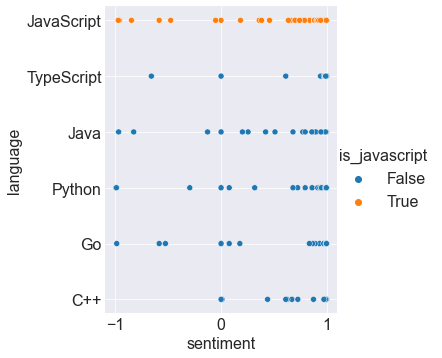

In [56]:
plot = sns.relplot(data = data, x = 'sentiment', y = 'language', hue = 'is_javascript')